In [ ]:
# Build a Conversational RAG Retrieval QA Chain with proper citations, like [1][2] with article title, pages and context
# This (RAG_QA_Cita-3.ipynb) is combined from the Resource 1 (RAG_QA_Cita.ipynb) and 2 (RAG_QA_Cita-2.ipynb), and citation style from ChatGPT (RAG_pipeline.ipynb)

In [1]:
# Read Resource 1. <How to get your RAG application to return sources?> (https://python.langchain.com/docs/how_to/qa_sources/)

# 1. use LangSmith
import getpass
import os

os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_API_KEY"] = getpass.getpass()

In [2]:
# Configure environment to connect to LangSmith.
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_ENDPOINT"]="https://api.smith.langchain.com"
os.environ["LANGSMITH_PROJECT"]="KI_multi-modal-RAG"

In [3]:
# 2. Components
# 2.1 Select chat model: Google Gemini

import getpass
import os

if not os.environ.get("GOOGLE_API_KEY"):
  os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter API key for Google Gemini: ")

from langchain.chat_models import init_chat_model

llm = init_chat_model("gemini-2.0-flash", model_provider="google_genai")


In [4]:
# 2.2 Select embedding model: HuggingFace
from langchain_huggingface import HuggingFaceEmbeddings

embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")

In [5]:
# 2.3 Select vector store: Chroma (install and upgrade langchain_chroma)
from langchain_chroma import Chroma

vector_store = Chroma(
    collection_name="example_collection",
    embedding_function=embeddings,
    persist_directory="./chroma_langchain_db",  # Where to save data locally, remove if not necessary
)

In [6]:
# 3. index our documents:

from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter

# 3.1 Load PDF files from a folder
import os
folder_path = r"D:\4-IntoCode\16_LangChain\AgilProjekt_multiModel\Raw_Data\Apple"  # company folder, Use raw string
all_docs = []

for file in os.listdir(folder_path):
    if file.endswith(".pdf"):
        loader = PyPDFLoader(os.path.join(folder_path, file))
        pages = loader.load_and_split()
        all_docs.extend(pages)

# 3.2 Split into chunks
splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
docs = splitter.split_documents(all_docs)
print(f"Loaded {len(docs)} chunks from {len(all_docs)} pages across {len(os.listdir(folder_path))} PDF files.")
# Result: "Loaded 4419 chunks from 1347 pages across 22 PDF files.


Loaded 4419 chunks from 1347 pages across 22 PDF files.


In [7]:
# 3.3 Index chunks
_ = vector_store.add_documents(documents=docs)

In [78]:
# 4. RAG application: reconstruct the Q&A app with sources
# Conversational RAG: additional tool-calling features of chat models, a "back-and-forth" conversational user experience.
# Read Resource 2. <How to get a RAG application to add citations?> (https://python.langchain.com/docs/how_to/qa_citations/)
# get a model to cite which parts of the source documents it referenced in generating its response.
# Method: Using tool-calling to cite document IDs;

# 4.1 Define the tool
from langchain_core.tools import tool


@tool(response_format="content_and_artifact")
def retrieve(query: str):
    """Retrieve information related to a query."""
    retrieved_docs = vector_store.similarity_search(query, k=2)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\n" f"Content: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs

In [80]:
# build and compile the exact same application with 2 changes:
# 1. add a context key of the state to store retrieved documents;
# 2. In the generate step, we pluck out the retrieved documents and populate them in the state.
from langchain_core.messages import SystemMessage
from langgraph.graph import MessagesState
from langgraph.prebuilt import ToolNode
from typing import List
from langchain_core.documents import Document

# Define state for application (modified)
class State(MessagesState):
    context: List[Document] # change 1


# Step 1: Generate an AIMessage that may include a tool-call to be sent.
def query_or_respond(state: State):
    """Generate tool call for retrieval or respond."""
    llm_with_tools = llm.bind_tools([retrieve])
    response = llm_with_tools.invoke(state["messages"])
    # MessagesState appends messages to state instead of overwriting
    return {"messages": [response]}


# Step 2: Execute the retrieval.
tools = ToolNode([retrieve])

# load a retriever and construct our prompt:
# In the article 2, the author uses WikipediaRetriever, but we can use our own vector store.
retriever = vector_store.as_retriever() # use our own vector store
retriever.search_kwargs["k"] = 4  # number of documents to retrieve

# Step 3: Generate a response using the retrieved content.
def generate(state: MessagesState):
    """Generate answer."""
    # Get generated ToolMessages
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]

    # Format into prompt (customize the prompt)
    docs_content = "\n\n".join(doc.content for doc in tool_messages)
    system_message_content = (
        """You are an assistant for question-answering tasks. 
        ONLY Use the following pieces of retrieved context to answer the question. 
        For each fact, cite its source number like [1][2]. 
        At the end of your answer, add a list of sources in the format of [1] <source title>, page <page number> and so on.
        If you don't know the answer, If unsure, say 'I don't know'."""
        "\n\n"
        f"{docs_content}"
    )
    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]
    prompt = [SystemMessage(system_message_content)] + conversation_messages

    # Process and format the answer 
    result = llm.invoke(prompt)

    # Get the content of the AI message
    answer = result.content.strip()

    # Try to get any custom metadata or sources (if your LLM provides it through a custom return)
    sources = result.additional_kwargs.get("source_documents", [])
    
    # Add formatted citations (with prefered cictation style)
    if sources:
        answer += "\n\nSources:"
        for i, doc in enumerate(sources, start=1):
            source_info = doc.metadata.get('source', 'Unknown document')
            page_info = f", page {doc.metadata['page']}" if 'page' in doc.metadata else ""
            answer += f"\n[{i}] {source_info}{page_info}"
    
    print("Answer:\n", answer)
    
    # Run
    context = []
    for tool_message in tool_messages:                  # change 2
        context.extend(tool_message.artifact)
    return {"messages": [result], "context": context}

In [81]:
# compile the application:
from langgraph.graph import StateGraph
from langgraph.graph import END
from langgraph.prebuilt import tools_condition


graph_builder = StateGraph(MessagesState)

graph_builder.add_node(query_or_respond)
graph_builder.add_node(tools)
graph_builder.add_node(generate)

graph_builder.set_entry_point("query_or_respond")
graph_builder.add_conditional_edges(
    "query_or_respond",
    tools_condition,
    {END: END, "tools": "tools"},
)
graph_builder.add_edge("tools", "generate")
graph_builder.add_edge("generate", END)

graph = graph_builder.compile()

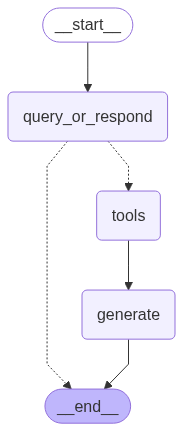

In [82]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [84]:
# Invoking our application, the retrieved Document objects are accessible from the application state.
input_message = "What is Total net sales in 2020 in Apple Inc.?" # the answer should be with ToolMessage

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

What is Total net sales in 2020 in Apple Inc.?
================================== Ai Message ==================================
Tool Calls:
  retrieve (3ccf6167-76b8-4c43-bbff-60a3cd27bde5)
 Call ID: 3ccf6167-76b8-4c43-bbff-60a3cd27bde5
  Args:
    query: Total net sales in 2020 in Apple Inc.
================================= Tool Message =================================
Name: retrieve

Source: {'author': 'anonymous', 'creationdate': '2022-10-27T16:05:06+00:00', 'creator': 'Workiva', 'moddate': '2022-10-27T16:05:06+00:00', 'page': 39, 'page_label': '40', 'producer': 'Wdesk Fidelity Content Translations Version 006.012.078', 'source': 'D:\\4-IntoCode\\16_LangChain\\AgilProjekt_multiModel\\Raw_Data\\Apple\\10-K-2022.pdf', 'title': '10-K 2022, 09.24.2022-2022-10-27-08-59', 'total_pages': 80}
Content: 2022 2021 2020
iPhone (1) $ 205,489 $ 191,973 $ 137,781 
Mac (1)  40,177  35,190  28,622 
iPad (1)  29,292  

In [85]:
step["context"]

[Document(id='5266b8c1-a6c1-468f-8a95-ddd18341c7eb', metadata={'author': 'anonymous', 'creationdate': '2022-10-27T16:05:06+00:00', 'creator': 'Workiva', 'moddate': '2022-10-27T16:05:06+00:00', 'page': 39, 'page_label': '40', 'producer': 'Wdesk Fidelity Content Translations Version 006.012.078', 'source': 'D:\\4-IntoCode\\16_LangChain\\AgilProjekt_multiModel\\Raw_Data\\Apple\\10-K-2022.pdf', 'title': '10-K 2022, 09.24.2022-2022-10-27-08-59', 'total_pages': 80}, page_content='2022 2021 2020\niPhone (1) $ 205,489 $ 191,973 $ 137,781 \nMac (1)  40,177  35,190  28,622 \niPad (1)  29,292  31,862  23,724 \nWearables, Home and Accessories (1)(2)  41,241  38,367  30,620 \nServices (3)  78,129  68,425  53,768 \nTotal net sales (4) $ 394,328 $ 365,817 $ 274,515 \n(1) Products net sales include amortization of the deferred value of unspecified software upgrade rights, which are bundled in \nthe sales price of the respective product.\n(2) Wearables, Home and Accessories net sales include sales of A